In [5]:
# -*- coding: utf-8 -*-
"""
Weakly Supervised Learning (Cats vs Dogs, CIFAR-10)
- Inaccurate supervision: inject noisy labels into training set
- Robust training: Bootstrap Loss
- Metrics logging per epoch: train loss, train acc (noisy), val acc (true), val AUC (true)
- Final eval: test accuracy/AUC, ROC curve, confusion matrix
- Outputs: CSV + PNG charts saved to ./outputs
"""

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import torchvision.transforms as T

# -------------------------
# 0) Reproducibility & config
# -------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

SAVE_DIR = "./outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# training hyper-params
EPOCHS = 10          # 可适当增大以获得更平滑曲线（例如 20）
BATCH = 128
LR = 1e-3
BETA = 0.8           # BootstrapLoss 的混合系数（越接近1越接近用标签）
NOISE_RATE = 0.20    # 训练集中多少比例标签将被随机翻转（模拟弱标签的错误）

# -------------------------
# 1) Data: CIFAR-10 -> filter cats(3) & dogs(5)
# -------------------------
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

trainset_raw = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset_raw  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

def filter_cats_dogs(dataset):
    xs, ys_true = [], []
    for img, label in dataset:
        if label in (3, 5):            # 3=cat, 5=dog
            xs.append(img.unsqueeze(0)) # [C,H,W] -> [1,C,H,W]
            ys_true.append(0 if label == 3 else 1)  # cat=0, dog=1
    X = torch.cat(xs, dim=0)            # [N, C, H, W]
    y_true = torch.tensor(ys_true, dtype=torch.float32)  # [N]
    return X, y_true

X_train_all, y_train_true_all = filter_cats_dogs(trainset_raw)  # ~10000中的cat/dog子集
X_test, y_test_true = filter_cats_dogs(testset_raw)

# 划分 train/val（保持 val/test 标签干净，用于客观评估）
N = len(X_train_all)
n_train = int(0.85 * N)      # 85% 作为训练，其余做验证（你也可以 70/15/15）
n_val = N - n_train

full_ds = TensorDataset(X_train_all, y_train_true_all)
train_ds_raw, val_ds_raw = random_split(
    full_ds, [n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

# 从 split 中拿出张量
def tensors_from_subset(subset):
    xs, ys = [], []
    for x, y in subset:
        xs.append(x.unsqueeze(0))
        ys.append(y.item())
    X = torch.cat(xs, dim=0)
    y = torch.tensor(ys, dtype=torch.float32)
    return X, y

X_train, y_train_true = tensors_from_subset(train_ds_raw)
X_val,   y_val_true   = tensors_from_subset(val_ds_raw)



In [6]:
# ---------- 注入噪声（仅训练集） ----------
y_train_noisy = y_train_true.clone()
num_noisy = int(NOISE_RATE * len(y_train_noisy))
noise_idx = np.random.choice(len(y_train_noisy), num_noisy, replace=False)
y_train_noisy[noise_idx] = 1.0 - y_train_noisy[noise_idx]
print(f"[INFO] Train samples: {len(y_train_true)} | Inject noisy labels: {num_noisy} ({NOISE_RATE*100:.1f}%)")

# -------------------------
# 2) DataLoaders
# -------------------------
train_loader = DataLoader(TensorDataset(X_train, y_train_noisy, y_train_true), batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   y_val_true), batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test,  y_test_true), batch_size=BATCH, shuffle=False)


[INFO] Train samples: 8500 | Inject noisy labels: 1700 (20.0%)


In [9]:

# -------------------------
# 3) Model
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 32x32x32
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 64x16x16
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2) # 128x8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 256), nn.ReLU(),
            nn.Linear(256, 1), nn.Sigmoid()
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(DEVICE)

# -------------------------
# 4) Loss & Optimizer
# -------------------------
class BootstrapLoss(nn.Module):
    """
    y_soft = beta * y_noisy + (1 - beta) * p.detach()
    loss = BCE(p, y_soft)
    """
    def __init__(self, beta=0.8):
        super().__init__()
        self.beta = beta
        self.bce = nn.BCELoss()
    def forward(self, preds, labels_noisy):
        soft = self.beta * labels_noisy + (1.0 - self.beta) * preds.detach()
        return self.bce(preds, soft)

criterion = BootstrapLoss(beta=BETA)
optimizer = optim.Adam(model.parameters(), lr=LR)



# -------------------------
# 5) Helpers
# -------------------------
@torch.no_grad()
def eval_loader_classification(loader, model, device):
    model.eval()
    y_list, p_list = [], []
    for batch in loader:
        if len(batch) == 2:
            xb, yb_true = batch
        else:
            xb, yb_true = batch[0], batch[1]  # 兼容(TensorDataset(X, y))
        xb = xb.to(device)
        preds = model(xb).squeeze(1).cpu().numpy()
        p_list.append(preds)
        y_list.append(yb_true.numpy())
    y = np.concatenate(y_list)
    p = np.concatenate(p_list)
    y_bin = (p >= 0.5).astype(int)
    acc = accuracy_score(y, y_bin)
    try:
        auc = roc_auc_score(y, p)
    except ValueError:
        auc = np.nan
    return acc, auc, y, p


In [10]:
# -------------------------
# 6) Train loop with logging
# -------------------------
history = {"epoch":[], "train_loss":[], "train_acc_noisy":[], "val_acc_true":[], "val_auc_true":[]}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    # 记录训练集对“噪声标签”的拟合情况
    train_preds, train_labels_noisy = [], []

    for xb, yb_noisy, yb_true in train_loader:
        xb = xb.to(DEVICE)
        yb_noisy = yb_noisy.to(DEVICE)

        preds = model(xb).squeeze(1)
        loss = criterion(preds, yb_noisy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_preds.append(preds.detach().cpu().numpy())
        train_labels_noisy.append(yb_noisy.detach().cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_preds = np.concatenate(train_preds)
    train_labels_noisy = np.concatenate(train_labels_noisy)
    train_acc_noisy = accuracy_score(train_labels_noisy, (train_preds >= 0.5).astype(int))

    # 验证集（使用干净标签）
    val_acc, val_auc, _, _ = eval_loader_classification(val_loader, model, DEVICE)

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_acc_noisy"].append(train_acc_noisy)
    history["val_acc_true"].append(val_acc)
    history["val_auc_true"].append(val_auc)

    print(f"[Epoch {epoch:02d}] loss={train_loss:.4f}  train_acc(noisy)={train_acc_noisy:.3f}  "
          f"val_acc(true)={val_acc:.3f}  val_auc(true)={val_auc:.3f}")




[Epoch 01] loss=0.6916  train_acc(noisy)=0.520  val_acc(true)=0.594  val_auc(true)=0.619
[Epoch 02] loss=0.6845  train_acc(noisy)=0.558  val_acc(true)=0.595  val_auc(true)=0.651
[Epoch 03] loss=0.6746  train_acc(noisy)=0.583  val_acc(true)=0.652  val_auc(true)=0.699
[Epoch 04] loss=0.6689  train_acc(noisy)=0.585  val_acc(true)=0.655  val_auc(true)=0.729
[Epoch 05] loss=0.6567  train_acc(noisy)=0.610  val_acc(true)=0.683  val_auc(true)=0.749
[Epoch 06] loss=0.6462  train_acc(noisy)=0.630  val_acc(true)=0.702  val_auc(true)=0.756
[Epoch 07] loss=0.6364  train_acc(noisy)=0.638  val_acc(true)=0.677  val_auc(true)=0.750
[Epoch 08] loss=0.6257  train_acc(noisy)=0.654  val_acc(true)=0.672  val_auc(true)=0.756
[Epoch 09] loss=0.6148  train_acc(noisy)=0.662  val_acc(true)=0.689  val_auc(true)=0.764
[Epoch 10] loss=0.5972  train_acc(noisy)=0.682  val_acc(true)=0.693  val_auc(true)=0.767


In [11]:
# -------------------------
# 7) Save history CSV
# -------------------------
df_hist = pd.DataFrame(history)
csv_path = os.path.join(SAVE_DIR, "wsl_training_history.csv")
df_hist.to_csv(csv_path, index=False)
print(f"[SAVE] history -> {csv_path}")

# -------------------------
# 8) Draw charts (each in its own figure; no custom colors/styles)
# -------------------------
# Loss
plt.figure()
plt.plot(df_hist["epoch"], df_hist["train_loss"], marker="o")
plt.title("Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
loss_png = os.path.join(SAVE_DIR, "training_loss.png")
plt.savefig(loss_png, bbox_inches="tight"); plt.close()
print(f"[SAVE] {loss_png}")

# Accuracy curves
plt.figure()
plt.plot(df_hist["epoch"], df_hist["train_acc_noisy"], marker="o", label="Train Acc (noisy)")
plt.plot(df_hist["epoch"], df_hist["val_acc_true"], marker="s", label="Val Acc (true)")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
acc_png = os.path.join(SAVE_DIR, "accuracy_curves.png")
plt.savefig(acc_png, bbox_inches="tight"); plt.close()
print(f"[SAVE] {acc_png}")

# -------------------------
# 9) Final test evaluation & plots
# -------------------------
test_acc, test_auc, y_true_test, y_prob_test = eval_loader_classification(test_loader, model, DEVICE)

# ROC
fpr, tpr, _ = roc_curve(y_true_test, y_prob_test)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve (Test)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend()
roc_png = os.path.join(SAVE_DIR, "roc_curve_test.png")
plt.savefig(roc_png, bbox_inches="tight"); plt.close()
print(f"[SAVE] {roc_png}")

# Confusion Matrix (threshold=0.5)
y_pred_bin = (y_prob_test >= 0.5).astype(int)
cm = confusion_matrix(y_true_test, y_pred_bin)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
cm_png = os.path.join(SAVE_DIR, "confusion_matrix_test.png")
plt.savefig(cm_png, bbox_inches="tight"); plt.close()
print(f"[SAVE] {cm_png}")

# Summary TXT
with open(os.path.join(SAVE_DIR, "metrics_summary.txt"), "w") as f:
    f.write(f"Test Accuracy (true labels): {test_acc:.4f}\n")
    f.write(f"Test ROC-AUC: {test_auc:.4f}\n")
    f.write(f"Noise rate used for training labels: {NOISE_RATE:.2f}\n")

print(f"[DONE] Test Acc={test_acc:.4f}  Test AUC={test_auc:.4f}")
print(f"Outputs saved to: {os.path.abspath(SAVE_DIR)}")

[SAVE] history -> ./outputs/wsl_training_history.csv
[SAVE] ./outputs/training_loss.png
[SAVE] ./outputs/accuracy_curves.png
[SAVE] ./outputs/roc_curve_test.png
[SAVE] ./outputs/confusion_matrix_test.png
[DONE] Test Acc=0.6930  Test AUC=0.7596
Outputs saved to: /content/outputs


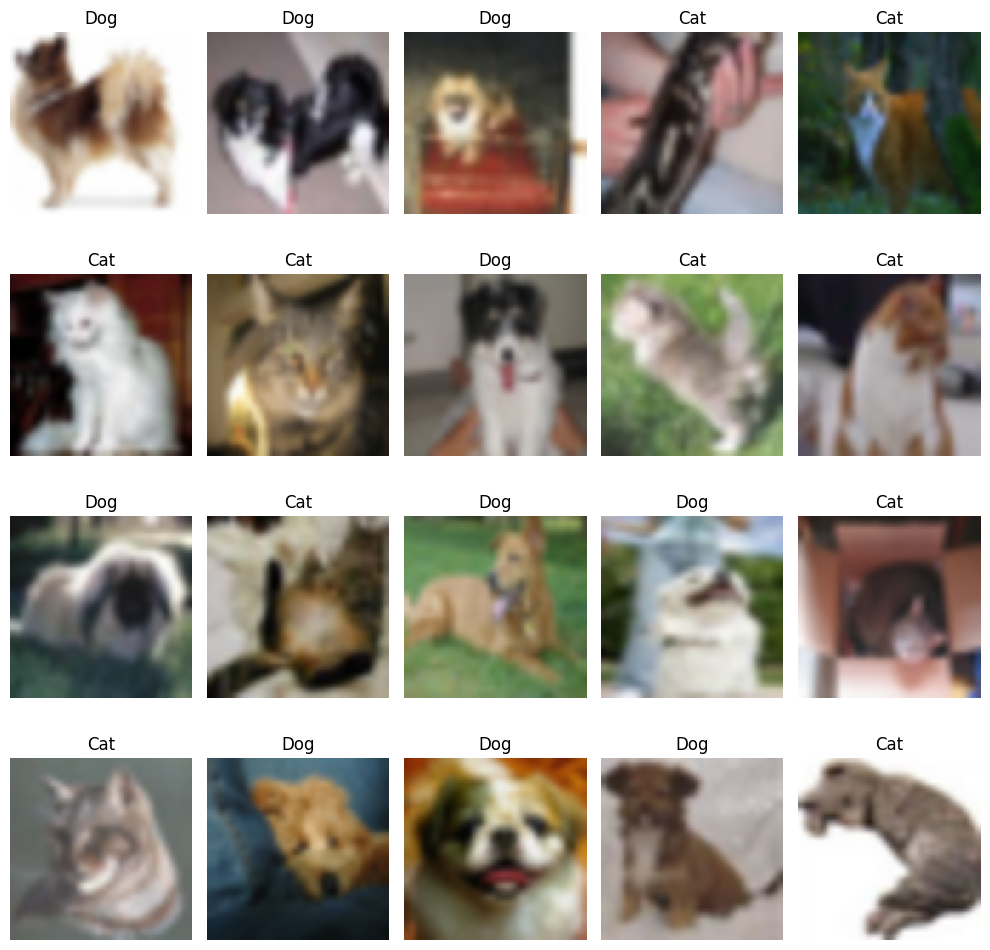

In [4]:
import matplotlib.pyplot as plt
import random

# Combine train and test sets for display
X_combined = torch.cat((X_train, X_test))
y_combined = torch.cat((y_train, y_test))

# Get indices of cats and dogs
cat_indices = [i for i, label in enumerate(y_combined) if label == 0]
dog_indices = [i for i, label in enumerate(y_combined) if label == 1]

# Randomly select 10 cat and 10 dog indices
selected_cat_indices = random.sample(cat_indices, 10)
selected_dog_indices = random.sample(dog_indices, 10)

# Combine the selected indices and shuffle
selected_indices = selected_cat_indices + selected_dog_indices
random.shuffle(selected_indices)

# Display the images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(selected_indices):
    plt.subplot(4, 5, i + 1)
    # Convert the image tensor to numpy and transpose for plotting (C, H, W) -> (H, W, C)
    img = X_combined[idx].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title("Cat" if y_combined[idx] == 0 else "Dog")
    plt.axis('off')

plt.tight_layout()
plt.show()

Found 4 images in ./outputs: ['confusion_matrix_test.png', 'training_loss.png', 'roc_curve_test.png', 'accuracy_curves.png']


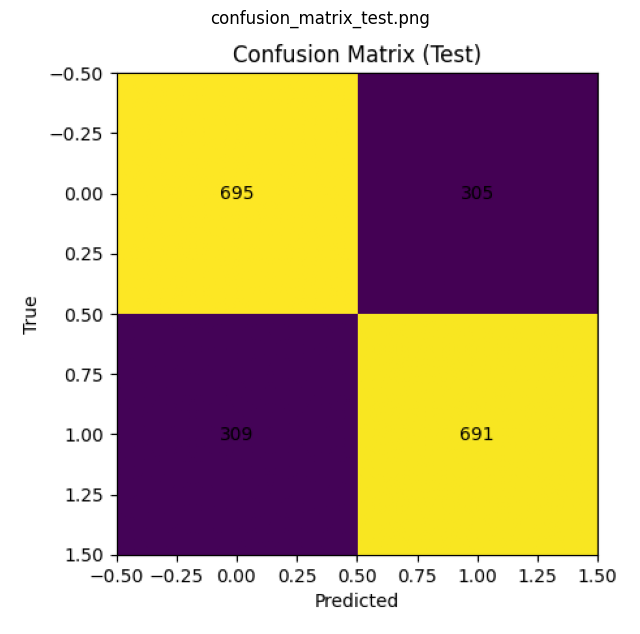

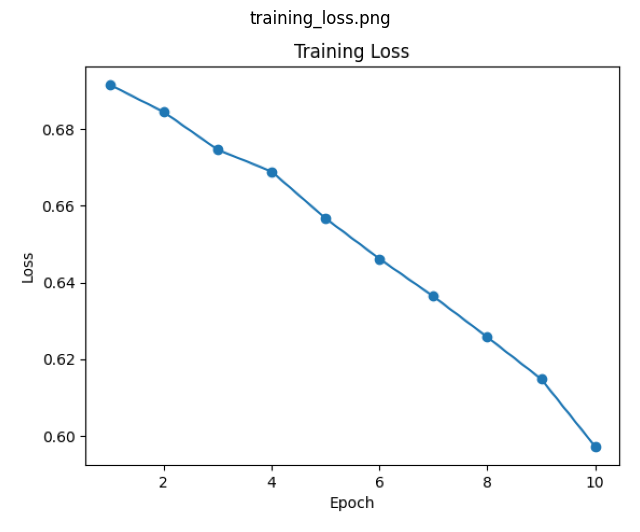

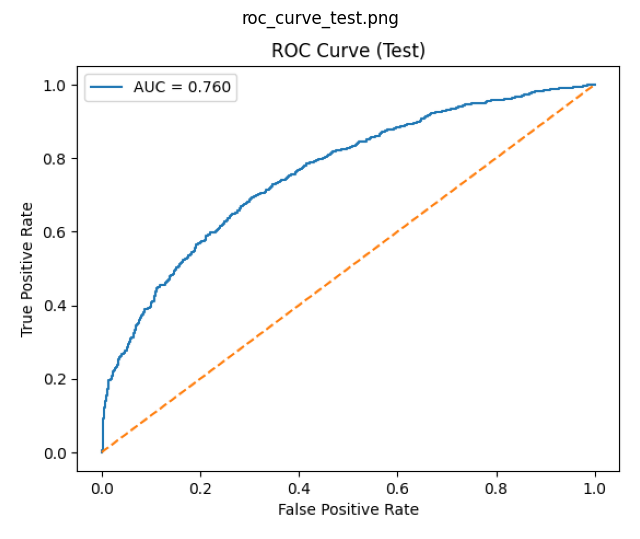

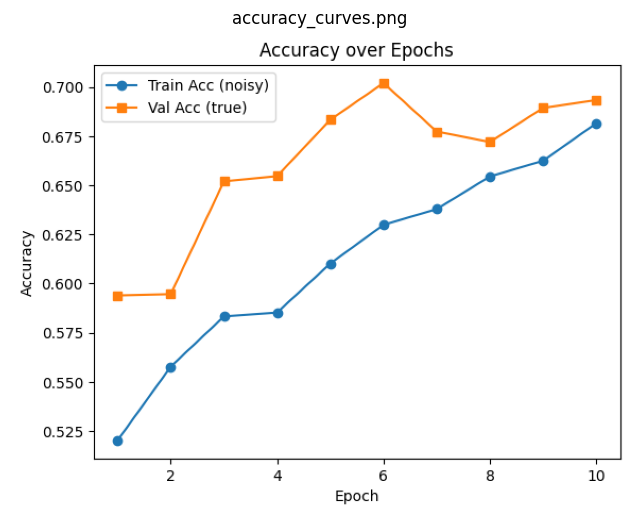

In [12]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

output_dir = "./outputs"
image_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]

if not image_files:
    print(f"No image files found in {output_dir}")
else:
    print(f"Found {len(image_files)} images in {output_dir}: {image_files}")
    for img_file in image_files:
        img_path = os.path.join(output_dir, img_file)
        try:
            img = mpimg.imread(img_path)
            plt.figure(figsize=(8, 8))
            plt.imshow(img)
            plt.title(img_file)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Could not display {img_file}: {e}")